In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 9
import numpy as np
from scipy.signal import argrelextrema
import datetime
import matplotlib.dates
import matplotlib.ticker as ticker
import math

In [181]:
def loadfile(train = True):
    if train:
        p_btce = pickle.load(open( "btce_all2.depth", "rb" ))
        p_stamp = pickle.load(open( "stamp_all2.depth", "rb" ))
    else:
        p_btce = pickle.load(open( "btce3.depth", "rb" ))
        p_stamp = pickle.load(open( "stamp3.depth", "rb" ))        
    res = prepare(p_btce, p_stamp)
    s_diff = pd.DataFrame(res).set_index(0)[1]
    return s_diff

def prepare(fullList1, fullList2):
    result = []
    gen2 = (x for x in fullList2)
    try:
        item2 = gen2.next()
        for item1 in fullList1:
            if (item1 is None):
                continue
            while (item2 is None) or (item2[0] < item1[0]):
                item2 = gen2.next()
            if abs(item2[0] - item1[0] > 10):  # time difference too large, discard
                continue
            result.append(update(item1, item2))
    except Exception, e:
        pass
    return result

def update(newPrice1=None, newPrice2=None):
    """
    item = (int[timestamp], float['bid1'][price], float['bid1'][volume], float['ask1'][price], float['ask1'][volume])
    """

    try:
        diff = float((newPrice1[3] - newPrice2[1]))
        #newPrice3 = average
        #if diff > newPrice3[1]:
        #    diff = float((newPrice1[1] - newPrice2[3]))
        #else:
        #    diff = float((newPrice1[3] - newPrice2[1]))
    except Exception, e:
        pass
    return (int(newPrice1[0]), diff)

def createLabel(s_diff):
    s_diff_mean = pd.rolling_mean(s_diff,100, center = True)
    s_diff_mean = pd.rolling_mean(s_diff_mean,200, center = True)
    x = s_diff_mean.values
    mmax = s_diff_mean[argrelextrema(x, np.greater)[0]].index # local maximum index
    mmin = s_diff_mean[argrelextrema(x, np.less)[0]].index # local minimum index

    # Series to DataFrame
    df = pd.DataFrame(s_diff_mean, columns = ['mean']).reset_index()
    df.columns = ['time','mean']
    df['price'] = s_diff.reset_index()[1]
    df['time'] = pd.to_datetime(df['time'],unit='s')

    # plt.plot(df['time'], df['max'],'b^')
    # df_max = df.ix[mmax]
    # df_min = df.ix[mmin]

    # rolling max
    df['max'] = pd.rolling_max(df['price'], 200, center = True)

    # filling the region near argmax with max value
    df.ix[mmax,'newmax'] = df.ix[mmax, 'max']
    df['newmax'] = df['newmax'].fillna(method='ffill', limit = 100)
    df['newmax'] = df['newmax'].fillna(method='bfill', limit = 100)
    # replace max value with true price
    df['newmax'] = df[df['newmax'].notnull()].price
    # filter out values with large price
    df['newmax'] = df[df['newmax'] > df['mean'] + 0].newmax

    # rolling min
    df['min'] = pd.rolling_min(df['price'], 200, center = True)

    # filling the region near argmin with min value
    df.ix[mmin,'newmin'] = df.ix[mmin, 'min']
    df['newmin'] = df['newmin'].fillna(method='ffill', limit = 100)
    df['newmin'] = df['newmin'].fillna(method='bfill', limit = 100)
    # replace min value with true price
    df['newmin'] = df[df['newmin'].notnull()].price
    # filter out values with smaller price
    df['newmin'] = df[df['newmin'] < df['mean'] - 0].newmin
    
#     plt.figure()
#     fig, ax = plt.subplots()
#     plt.plot(df['time'], df['price'],'y')
#     plt.plot(df['time'], df['mean'],'b')
#     # plt.plot(df_max['time'], df_max['mean'],'b^')
#     # plt.plot(df_min['time'], df_min['mean'],'r^')

#     plt.plot(df['time'], df['newmax'],'b^')
#     plt.plot(df['time'], df['newmin'],'r^')

#     df['newmax2'] = df['newmax'].fillna(method='ffill', limit = 50)
#     df['newmax2'] = df['newmax'].fillna(method='bfill', limit = 50)
#     df['newmin2'] = df['newmin'].fillna(method='ffill', limit = 50)
#     df['newmin2'] = df['newmin'].fillna(method='bfill', limit = 50)

#     df['newmax3'] = pd.rolling_mean(df['newmax2'],30, center = True)
#     df['newmin3'] = pd.rolling_mean(df['newmin2'],30, center = True)

    # plt.plot(df['time'], pd.rolling_mean(df['newmax2'],80, center = True) ,'bo')
    # plt.plot(df['time'], pd.rolling_mean(df['newmin2'],80, center = True) ,'ro')

#     ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m%d-%H'))
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.grid(which = 'major')
#     plt.show()
    return df
#     plt.plot(df['time'], df['price'],'y')
#     plt.plot(df['time'], df['mean'],'b')
#     plt.plot(df['time'], df['newmax3'],'b^')
#     plt.plot(df['time'], df['newmin3'],'r^')
#     plt.show()

def filterLabel(df):
    count = 0
    thres = 4
    lastbuy = 0
    lastsell = 0
    last_action = ""
    res = []
    for index, row in df.iterrows():
        if not math.isnan(row.newmax):
            if row.price > lastbuy + thres:
                if last_action == 'sell' and row.price > lastsell:
                    lastsell = row.price
                elif last_action != 'sell':
                    count += 1
                    lastsell = row.price
                res.append((row.time, row.price, 'sell', count))
                last_action = 'sell'
        if not math.isnan(row.newmin):
            if row.price < lastsell - thres:
                if last_action == 'buy' and row.price < lastbuy:
                    lastbuy = row.price
                elif last_action != 'buy':
                    count += 1
                    lastbuy = row.price
                res.append((row.time, row.price, 'buy', count))
                last_action = 'buy'
#     totaltradecount = count
    return pd.DataFrame(res, columns = ['time', 'price', 'action', 'tradecount'])


def filterTradePoints(dftrade):
    res = []
    avgprice = []
    for name, group in dftrade.groupby('tradecount'):
        if len(group)>5:
            asc = True
            mul = -1
            if group.iloc[0].action == 'sell':
                asc=False
                mul = 1
            tmp = (group.sort(columns = 'price',ascending=asc)[:30]).sort(columns = 'time')
            avgprice.append(mul * tmp['price'].mean())
            res.append(tmp)
    dftrade = pd.concat(res)
    # print sum(avgprice[:])- 1.5 * len(avgprice)
    return dftrade

def filterValidTrades(dftrade):
#     res = []
#     nextMean = 0
#     nextAct = ''
#     for name, group in sorted(dftrade.groupby('tradecount').groups.iteritems(), reverse=True)
#         if group.iloc[0].action != nextAct:
#             nextAct = group.iloc[0].action
#             res.append(group)
#         else:
#             if nextAct == 'sell' and nextMean
    lastAct = ''
    lastTradeCount = 0
    res = []
    for name, group in dftrade.groupby('tradecount'):
        if group.iloc[0].action != lastAct:
            lastAct = group.iloc[0].action
            lastTradeCount = group.iloc[0].tradecount
        else:
            group['tradecount'] = lastTradeCount
        res.append(group)
    dftrade = pd.concat(res)
    res = []
    for name, group in dftrade.groupby('tradecount'):
        asc = True
        if group.iloc[0].action == 'sell':
            asc=False
        tmp = (group.sort(columns = 'price',ascending=asc)[:30]).sort(columns = 'time')
        res.append(tmp)
    dftrade = pd.concat(res)
    return dftrade

def createFeatures(df):
    f = df[['time', 'price']].set_index('time')
    windows = [40,100,200,300,500,1000,2000,3000]
    for window in windows:
        lengthname = str(window)
        f['mean'+lengthname] = pd.rolling_mean(f['price'],window)
        f['var'+lengthname] = pd.rolling_var(f['price'],window)
        # f['range'+lengthname] = pd.rolling_max(f['price'],window) - pd.rolling_min(f['price'],window)
    # f.plot()
    f = f.dropna()
    return f

def createLastTradeFeatures(df):
    id = df['label'] == 1
    df.ix[id, '_timelastbuy'] = df.ix[id].index
    df.ix[id, '_pricelastbuy'] = df.ix[id].price
    id = df.index[0]
    df.ix[id, '_timelastbuy'] = id
    df.ix[id, '_pricelastbuy'] = df.ix[id, 'price']
    df['_timelastbuy'].fillna(method = 'ffill', inplace = True)
    df['_pricelastbuy'].fillna(method = 'ffill', inplace = True)
    df['_timediffbuy'] =  (df.index - df['_timelastbuy']).astype('timedelta64[s]')
    df['_pricediffbuy'] =  df['price'] - df['_pricelastbuy']
    
    id = df['label'] == -1
    df.ix[id, '_timelastsell'] = df.ix[id].index
    df.ix[id, '_pricelastsell'] = df.ix[id].price
    id = df.index[0]
    df.ix[id, '_timelastsell'] = id
    df.ix[id, '_pricelastsell'] = df.ix[id, 'price']
    df['_timelastsell'].fillna(method = 'ffill', inplace = True)
    df['_pricelastsell'].fillna(method = 'ffill', inplace = True)
    df['_timediffsell'] =  (df.index - df['_timelastsell']).astype('timedelta64[s]')
    df['_pricediffsell'] =  df['price'] - df['_pricelastsell']    
    df.drop(df[['_timelastbuy', '_pricelastbuy', '_timelastsell', '_pricelastsell']], axis=1, inplace=True) 
    df.drop(df[['_timediffbuy', '_timediffsell']], axis=1, inplace=True)
    return df
        
    
def appendLabels(f, dftrade):
    f_trade = dftrade.set_index('time');
    f =f.join(f_trade['action'])
    f['label'] = 0
    f.ix[f['action'] == 'buy','label'] = 1
    f.ix[f['action'] == 'sell','label'] = -1
    del f['action']
    f = f.dropna()
    return f

def plotTrades(f, col='label'):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(f.index,f['price'],'y')
    fbuy = f[(f[col] == 1)]
    fsell = f[(f[col] == -1)]
    plt.plot(fbuy.index, fbuy['price'], 'ro')
    plt.plot(fsell.index, fsell['price'], 'bo')
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m%d-%H'))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid(which = 'major')
    plt.show()    


In [169]:
s_diff = loadfile()
df = createLabel(s_diff)    
dftrade = filterLabel(df)
dftrade = filterTradePoints(dftrade)
#dftrade = filterValidTrades(dftrade)

In [170]:
f = createFeatures(df)
f = appendLabels(f, dftrade)

In [12]:
f = createLastTradeFeatures(f)

In [8]:
f[sorted(f.columns)]

,_pricediffbuy,_pricediffsell,label,mean100,mean1000,mean20,mean2000,mean500,price,var100,var1000,var20,var2000,var500
time,,,,,,,,,,,,,,
2015-04-15 16:00:14,0.000,0.000,0,-0.00797,-0.356267,-0.46225,-0.141384,-0.342458,-0.560,0.108252,0.141827,0.044438,0.295767,0.146214
2015-04-15 16:00:25,0.000,0.000,0,-0.01251,-0.356805,-0.48215,-0.141759,-0.342836,-0.560,0.111213,0.141757,0.039780,0.295799,0.146307
2015-04-15 16:00:36,0.000,0.000,0,-0.01470,-0.357343,-0.47565,-0.142134,-0.343214,-0.560,0.113146,0.141686,0.037780,0.295832,0.146400
2015-04-15 16:00:47,0.020,0.020,0,-0.01669,-0.357861,-0.49405,-0.142499,-0.343552,-0.540,0.114853,0.141606,0.032789,0.295856,0.146476
2015-04-15 16:00:57,-0.113,-0.113,0,-0.02356,-0.358422,-0.51960,-0.142930,-0.344156,-0.673,0.119147,0.141645,0.027984,0.295941,0.146692
2015-04-15 16:01:08,0.440,0.440,0,-0.02490,-0.358430,-0.51685,-0.143080,-0.343656,-0.120,0.119225,0.141641,0.030131,0.295889,0.146791
2015-04-15 16:01:18,0.440,0.440,0,-0.02612,-0.358438,-0.51380,-0.143230,-0.343156,-0.120,0.119308,0.141637,0.032473,0.295837,0.146889
2015-04-15 16:01:29,0.440,0.440,0,-0.02911,-0.358356,-0.50425,-0.143380,-0.341096,-0.120,0.118963,0.141669,0.038375,0.295785,0.145680
2015-04-15 16:01:39,0.420,0.420,0,-0.03230,-0.358294,-0.49520,-0.143540,-0.339056,-0.140,0.118639,0.141693,0.043504,0.295733,0.144413


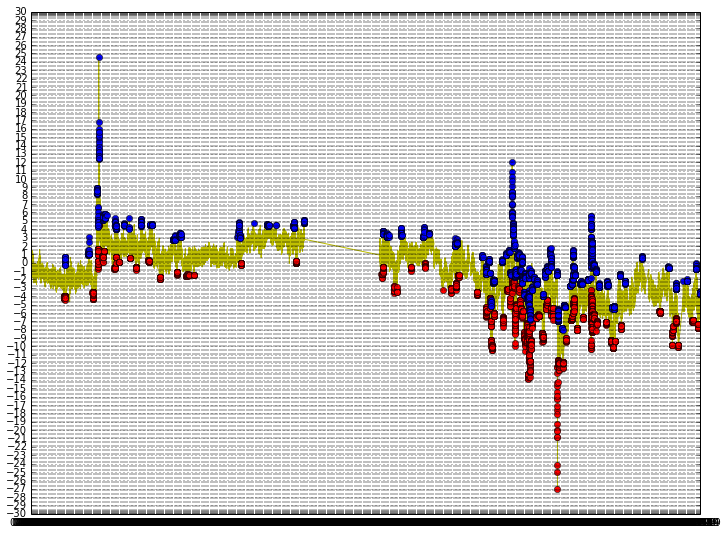

In [171]:
plotTrades(f)

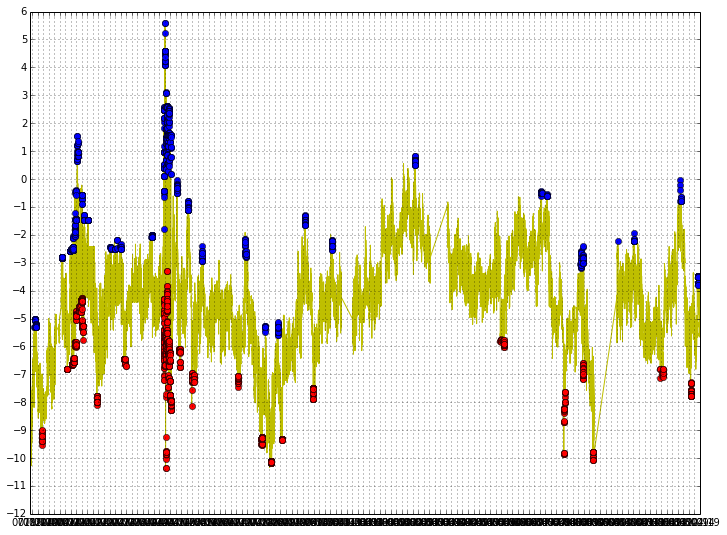

In [174]:
f = f[-170000:];plotTrades(f)

In [114]:
f[f['label'] == -1].count()

price       1685
mean20      1685
var20       1685
mean100     1685
var100      1685
mean500     1685
var500      1685
mean1000    1685
var1000     1685
mean2000    1685
var2000     1685
label       1685
dtype: int64

             precision    recall  f1-score   support

         -1       0.41      0.55      0.47      1139
          0       0.99      0.99      0.99    167688
          1       0.38      0.49      0.43      1173

avg / total       0.99      0.98      0.98    170000



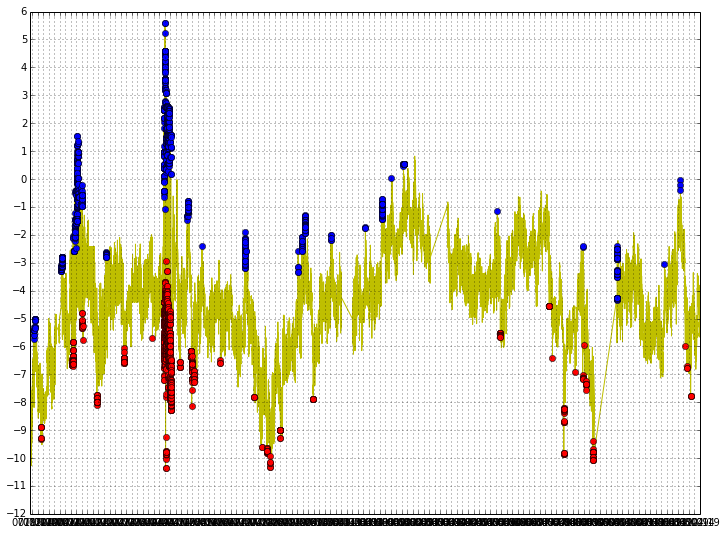

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
df = f.drop('label', axis=1)
data_train = df.as_matrix()
label_train = f.loc[:,'label'].as_matrix()

classifier = LogisticRegression(class_weight={1:70,-1:70})
classifier.fit(data_train,label_train)
predicted = classifier.predict(data_train)
expected = label_train
print metrics.classification_report(expected, predicted)
f_res = f.copy()
f_res['predict'] = predicted
plotTrades(f_res, col='predict')

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
f_res = f.copy()
f_train_buy = f.copy()
f_train_buy = f_train_buy[f_train_buy['label']!= -1]
f_train_buy = f_train_buy.drop('_pricediffbuy', axis=1)
df = f_train_buy.drop('label', axis=1)
data_train = df[sorted(df.columns)].as_matrix()
label_train = f_train_buy.loc[:,'label'].as_matrix()

classifier_buy = LogisticRegression(class_weight={1:50})
classifier_buy.fit(data_train,label_train)
predicted = classifier_buy.predict(data_train)
f_train_buy['predict_buy'] = predicted
f_res = f_res.join(f_train_buy['predict_buy'])

f_train_sell = f.copy()
f_train_sell = f_train_sell[f_train_sell['label']!= 1]
f_train_sell = f_train_sell.drop('_pricediffsell', axis=1)
df = f_train_sell.drop('label', axis=1)
data_train = df[sorted(df.columns)].as_matrix()
label_train = f_train_sell.loc[:,'label'].as_matrix()

classifier_sell = LogisticRegression(class_weight={-1:50})
classifier_sell.fit(data_train,label_train)
predicted = classifier_sell.predict(data_train)
f_train_sell['predict_sell'] = predicted
f_res = f_res.join(f_train_sell['predict_sell'])

In [10]:
len(data_train[0])

12

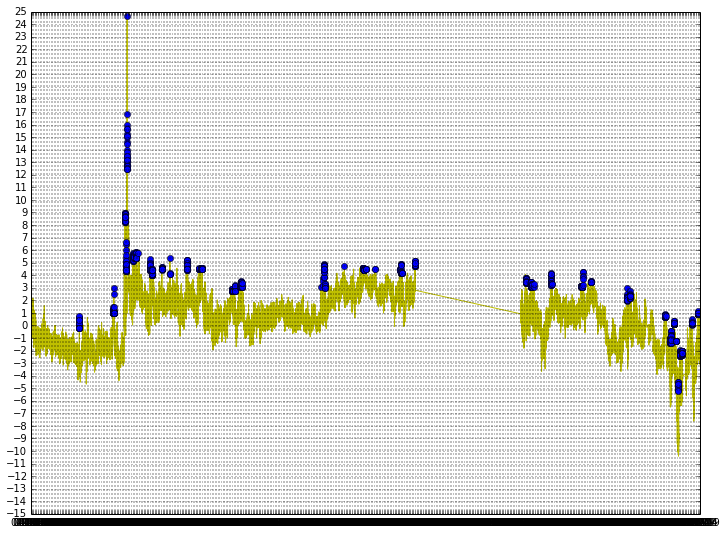

In [47]:
plotTrades(f_res, col='predict_sell')

In [153]:
s_diff_test = loadfile(train=False)
df = pd.DataFrame(s_diff_test.reset_index())
df.columns = ['time','price']
df['time'] = pd.to_datetime(df['time'],unit='s')
f_test = createFeatures(df)
# f_test['_pricediff'] = 0
# f_test = f_test[sorted(f_test.columns)]

In [148]:
id = f_test.index[0]
pricelastbuy = f_test.ix[id, 'price']
pricelastsell = pricelastbuy

In [26]:
row_sell

_pricediff    0.936000
mean100      -8.550110
mean1000     -8.385596
mean20       -8.320000
mean2000     -7.884799
mean500      -8.369048
price        -8.731000
var100        0.093223
var1000       0.480062
var20         0.022078
var2000       0.669720
var500        0.251668
Name: 2015-07-28 04:43:19, dtype: float64

In [32]:
for index, row in f_test.iterrows():
    row_buy = row.copy()
    row_sell = row.copy()
    row_sell['_pricediff'] = row['price'] - pricelastbuy
    row_buy['_pricediff'] = row['price'] - pricelastsell
    data_test_sell = row_sell.as_matrix()
    data_test_buy = row_buy.as_matrix()
    predicted_sell = classifier_sell.predict(data_test_sell)
    predicted_buy = classifier_buy.predict(data_test_buy)
    if predicted_sell[0] == -1:
        f_test.ix[index,'predict'] = predicted_sell
        pricelastsell = row['price']
    if predicted_buy[0] == 1:
        f_test.ix[index, 'predict'] = predicted_buy
        pricelastbuy = row['price']
        

KeyError: 'predict'

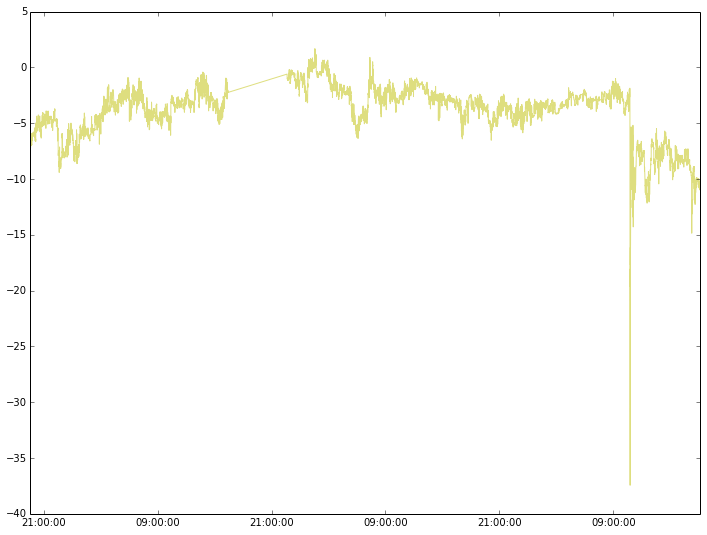

In [79]:
plt.figure()
fig, ax = plt.subplots()
plt.plot(f_test.index,f_test['price'],'y', alpha=0.5)

fbuy = f_test[(f_test['predict'] == 1)]
fsell = f_test[(f_test['predict'] == -1)]
# plt.scatter(fbuy.index, fbuy['price'],c=fbuy['prob0'],cmap = 'hot')
# plt.scatter(fsell.index, fsell['price'],c=fsell['prob0'],cmap = 'cool')

plt.plot(fbuy.index, fbuy['price'],'ro')
plt.plot(fsell.index, fsell['price'],'bo')

# plt.scatter(f_test.index, f_test['price'],c=f_test['prob0'],cmap = 'jet')
# plt.scatter(f_test.index, f_test['price'],c=f_test['prob2'],cmap = 'jet')

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m%d-%H'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(which = 'major')
plt.show()

In [182]:
s_diff_test = loadfile(train=False)
df = pd.DataFrame(s_diff_test.reset_index())
df.columns = ['time','price']
df['time'] = pd.to_datetime(df['time'],unit='s')
f_test = createFeatures(df)

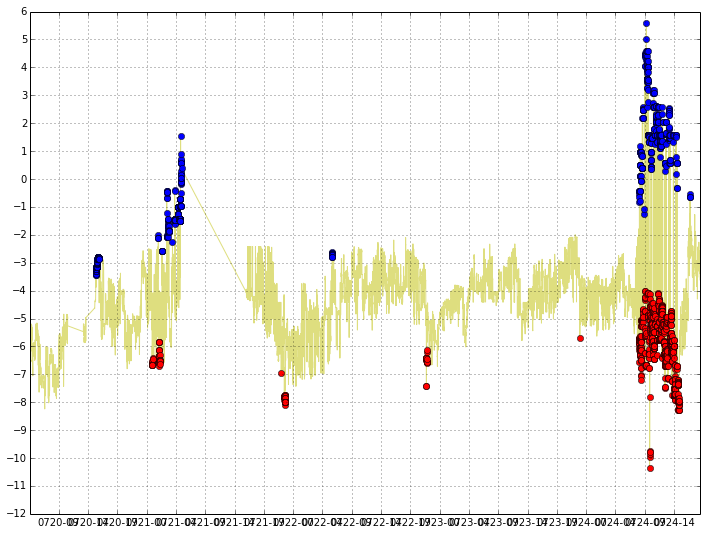

In [183]:
data_test = f_test.as_matrix()
predicted = classifier.predict(data_test)
prob = classifier.predict_proba(data_test)
f_test['predict'] = predicted
f_prob = pd.DataFrame(prob)
f_prob.columns = ['prob0','prob1','prob2']
f_prob.index = f_test.index
f_test = pd.concat([f_test, f_prob], axis = 1)
plt.figure()
fig, ax = plt.subplots()
plt.plot(f_test.index,f_test['price'],'y', alpha=0.5)

fbuy = f_test[(f_test['predict'] == 1)]
fsell = f_test[(f_test['predict'] == -1)]
# plt.scatter(fbuy.index, fbuy['price'],c=fbuy['prob0'],cmap = 'hot')
# plt.scatter(fsell.index, fsell['price'],c=fsell['prob0'],cmap = 'cool')

plt.plot(fbuy.index, fbuy['price'],'ro')
plt.plot(fsell.index, fsell['price'],'bo')

# plt.scatter(f_test.index, f_test['price'],c=f_test['prob0'],cmap = 'jet')
# plt.scatter(f_test.index, f_test['price'],c=f_test['prob2'],cmap = 'jet')

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m%d-%H'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(which = 'major')
plt.show()

In [184]:
with open('SmallBurger.model', 'wb') as mf:
    pickle.dump(classifier, mf)

In [118]:
with open('BurgerKing.model', 'rb') as mf:
    classifier = pickle.load(mf)

In [8]:
f_test

,price,mean20,var20,mean100,var100,mean500,var500,mean1000,var1000,mean2000,var2000,predict,prob0,prob1,prob2
time,,,,,,,,,,,,,,,
2015-08-09 12:18:58,-3.631,-3.66835,0.004756,-3.49773,0.058694,-4.159360,0.249303,-4.501342,0.503941,-4.575232,0.584843,0,0.015140,0.984510,0.000350
2015-08-09 12:19:09,-3.631,-3.67785,0.002014,-3.50230,0.057794,-4.158402,0.249857,-4.499063,0.502708,-4.574937,0.585225,0,0.015386,0.984268,0.000346
2015-08-09 12:19:19,-3.631,-3.67335,0.002010,-3.50731,0.056536,-4.157444,0.250409,-4.496784,0.501464,-4.574668,0.585589,0,0.015689,0.983966,0.000345
2015-08-09 12:19:29,-3.631,-3.66885,0.001964,-3.51232,0.055227,-4.156486,0.250959,-4.494505,0.500210,-4.574568,0.585757,0,0.016002,0.983654,0.000344
2015-08-09 12:19:40,-3.631,-3.66435,0.001875,-3.51733,0.053867,-4.155528,0.251507,-4.492226,0.498946,-4.574469,0.585925,0,0.016322,0.983335,0.000343
2015-08-09 12:19:50,-3.711,-3.66485,0.001918,-3.52314,0.052697,-4.154730,0.251898,-4.490027,0.497540,-4.574678,0.585475,0,0.010471,0.988979,0.000550
2015-08-09 12:20:00,-3.711,-3.66535,0.001961,-3.52895,0.051458,-4.153932,0.252288,-4.487828,0.496124,-4.574887,0.585027,0,0.010701,0.988755,0.000545
2015-08-09 12:20:11,-3.711,-3.66585,0.002004,-3.53476,0.050151,-4.153114,0.252678,-4.485629,0.494699,-4.574752,0.585224,0,0.010935,0.988525,0.000540
2015-08-09 12:20:21,-3.721,-3.66640,0.002061,-3.54067,0.048811,-4.152316,0.253049,-4.483440,0.493248,-4.574961,0.584780,0,0.010546,0.988886,0.000568


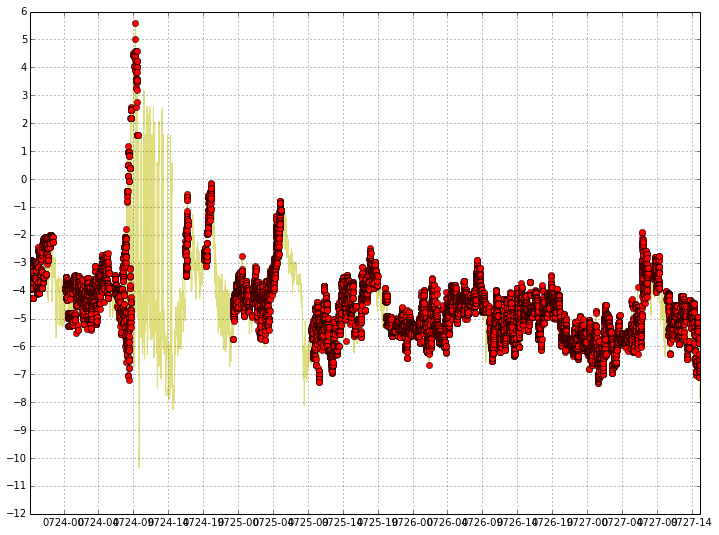

In [140]:
plt.figure()
fig, ax = plt.subplots()
plt.plot(f_test.index,f_test['price'],'y', alpha=0.5)

fbuy = f_test[(f_test['prob2'] >= 0.49)]
fsell = f_test[(f_test['prob0'] >= 0.1)]
# plt.scatter(fbuy.index, fbuy['price'],c=fbuy['prob0'],cmap = 'hot')
# plt.scatter(fsell.index, fsell['price'],c=fsell['prob0'],cmap = 'cool')

plt.plot(fbuy.index, fbuy['price'],'ro')
plt.plot(fsell.index, fsell['price'],'bo')

# plt.scatter(f_test.index, f_test['price'],c=f_test['prob0'],cmap = 'jet')
# plt.scatter(f_test.index, f_test['price'],c=f_test['prob2'],cmap = 'jet')

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m%d-%H'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(which = 'major')
plt.show()

In [45]:
sorted(dftrade.groupby('tradecount').groups.iteritems(), reverse=True)

[(292,
  [91828L,
   91829L,
   91830L,
   91831L,
   91832L,
   91833L,
   91834L,
   91835L,
   91836L,
   91837L,
   91838L,
   91839L,
   91840L,
   91841L,
   91842L,
   91843L,
   91844L,
   91845L,
   91846L,
   91847L,
   91848L,
   91849L,
   91850L,
   91851L,
   91852L,
   91853L,
   91854L]),
 (291,
  [91416L,
   91417L,
   91418L,
   91419L,
   91420L,
   91421L,
   91422L,
   91423L,
   91424L,
   91425L,
   91426L,
   91427L,
   91428L,
   91429L,
   91430L,
   91431L,
   91432L,
   91434L,
   91435L,
   91436L,
   91437L,
   91438L,
   91439L,
   91440L,
   91441L,
   91442L,
   91443L,
   91444L,
   91445L,
   91446L]),
 (290,
  [90593L,
   90672L,
   90673L,
   90674L,
   90690L,
   90691L,
   90692L,
   90693L,
   90694L,
   90708L,
   90709L,
   90710L,
   90711L,
   90712L,
   90713L,
   90714L,
   90715L,
   90716L,
   90726L,
   90727L,
   90730L,
   90731L,
   90737L,
   90738L,
   90740L,
   90741L,
   90788L,
   90789L,
   90792L,
   90793L]),
 (289,
  [89928L

In [142]:
len(f_test)

30494